<a href="https://colab.research.google.com/gist/Ridhima28/49092253926ebf06f0243cc9552e243f/dog_cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dogs Vs Cats Classification

## Data Acquistion 
We are using a [Dog Vs Cat dataset from Kaggle](https://www.kaggle.com/chetankv/dogs-cats-images).
If you have a Kaggle account, you can download the dataset from Kaggle directly. Follow instructions [here](https://www.kaggle.com/general/74235)


In [ ]:
!pip install kaggle

!mkdir .kaggle

import json
token = {"username":"ivyclare","key":"80b9df4293a9561cf2cd8d8fdfc6fcc"} # replace with your kaggle username and generated API Key
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
  
# Kaggle API for dataset 
!kaggle datasets download -d chetankv/dogs-cats-images
# !kaggle datasets download -d tawsifurrahman/covid19-radiography-database
# !kaggle competitions download -c histopathologic-cancer-detection

# unzip dataset after downloading
!unzip \*.zip


mkdir: cannot create directory ‘.kaggle’: File exists
401 - Unauthorized
unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
# IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/'
IMG_PATH = 'COVID-19 Radiography Database/' # unzipped folder

import os, shutil
# split the data by train/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
      dir  = os.path.isdir(IMG_PATH + CLASS)
      if dir:
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 0.8*IMG_NUM:
                shutil.copy(img, 'train/' + CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'test/'+ CLASS + '/' + FILE_NAME)
            # else:
          #     shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

FileNotFoundError: ignored

## Import Libraries

#### - **Pandas, Numpy, MatPlotLib**: 
For Data Manipulation & Visualization

#### - **Keras ImageDataGenerator**: 
For Image/Data Processing, Data Augmentation. 
Data augmentation is a strategy that enables us to significantly increase the diversity of data available for training models, without actually collecting new data. 
Data augmentation techniques such as **cropping, padding, and horizontal flipping** are commonly used to train large neural networks. [Read More](https://www.kdnuggets.com/2018/05/data-augmentation-deep-learning-limited-data.html)

#### - **Keras Models**: 
Sequential model for a sequential feed forward ConvNet, loading model from json file

#### - **Keras Layers**:
 Convolution, Max-Pooling, Activation, Flattening, Dense & Drop-Out Layers

#### - **Keras Backend**: 
how keras interacts with the input image structure

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dropout, Activation, Flatten, Dense
from keras.optimizers import Adam
from keras import backend as k
import tensorflow as tf

In [ ]:
# to hide the deprecation warnings (doesn't do much good though, we get a lot of warnings anyway - ignore them for now.
import warnings
warnings.filterwarnings('ignore', category= DeprecationWarning)

### Loading and Preprocessing Data

Loading data and performing preprocessing for every dataset is different. It depends on the dataset structure. 

In our dataset we have 2 main folders; **Training Set** and **Test Set**. 

And in each of these we have cat and dog folders.

In other datasets, we may have all images in one folder. In this case we will have split them into training and testing ourselves or even create the labels ourselves. 

Let's define certain parameters or hyperparameters for our model.

In [ ]:
# dimensions of our images
img_width, img_height = 224, 224
img_size = (224, 224)

# saving the directory/folder location for training and validation image folders to variables
train_data_dir = 'dataset/training_set'
test_data_dir = 'dataset/test_set'

# Saving the batch_size and epochs for training to variables
batch_size = 32 #usually in powers of 2 - 8, 16, 32, 64, 128
epochs = 15

Performing image augmentation and dividing our train set into training and validation sets.

We do this using Image Data Generator in keras. We have to create training and validation generators which contain images and labels.



In [ ]:
# Training ImagaDataGenerator with Augmentation transf.  
train_datagen = ImageDataGenerator(rescale=1./255, #normalization
                                   validation_split=0.2,
                                   shear_range = 0.2, # extent of shearing - 20% 
                                   zoom_range = 0.2, # extent of adjusting the zoom in images - 20%
                                   horizontal_flip= True, # randomly flipping to get mirror images 
                                   rotation_range=0.1)
                                   

# Validation ImageDataGenerator with rescaling.
# You should not apply any other transformations to the validation set because it has to reflect real world data
valid_datagen = ImageDataGenerator(rescale=1./255, 
                                   validation_split=0.2)




In [ ]:
# Create a flow from the directory using same seed and 'training' subset.
train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                              subset='training',
                                              shuffle=True, 
                                              seed=42, 
                                              target_size=img_size,
                                              batch_size=batch_size,
                                              class_mode='binary')

# Create a flow from the directory for validation data - seed=42
validation_generator = valid_datagen.flow_from_directory(train_data_dir, 
                                              subset='validation',
                                              seed=42, 
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='binary')

In [ ]:
# this batch of code checks for whether the backend (tensorflow in this case) supports the image input shape with the color
# before or after the image width and image height values. This input shape is passed as the input to the ConvNet.
if k.image_data_format() == "channels_first":
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
input_shape

### Build A Simple Convolutional Net

This is where we build the convolutional neural network architechture. 
Keras makes the building of the network super intuitive and as simple as adding layers to the network line by line. The design I've built here is simple enough with:

- Convolution layers (takes in how many convolution filters we want and the size of the convolution filter), 
- Activation layers (with Relu activation function), 
- Pooling layers (rather maxpooling layers for max-pooling function over the convoluted and activated layer), 
- Flattening layer to flatten the input at that layer to a single long list of values that are passed through a small dense neural network), 
- Dense Layer (simple neural network layer), 
- DropOut layer which this is used to prevent for over-fitting. You can understand it as a layer which ignores part of the input provided to it from its previous layer).

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model = tf.keras.models.Sequential([
    # First Convolution
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Second Convolution
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Third Convolution
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # Flatten
    tf.keras.layers.Flatten(),
    # Dense layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
# Saving the history of training epochs and associated metrics to a variable (history) 
history = model.fit(train_generator,epochs = epochs,
                             validation_data= validation_generator)


Saving Model

In [ ]:
# Writing the model to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
# save model and architecture to single file
model.save("full_model.h5")
print("Saved full model to disk")

#### Displaying Training History

In [ ]:
print(history.history.keys()) # prints what the history has stored (stored in a dictionary format (key-value pairs))

# summarize history for accuracy on a line chart
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss on a line chart
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Evaluate Model Performance

First Load Saved Model

In [ ]:
# load json file and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
from keras.models import load_model #to load the model saved as a h5 file
# load model
full_model = load_model('full_model.h5')

In [ ]:
# load test dataset
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a flow from the directory for validation data - seed=42
test_generator = test_datagen.flow_from_directory(test_data_dir,  
                                              target_size=img_size,
                                              batch_size = batch_size,
                                              class_mode='binary')

In [ ]:
# Prints out the model loss and accuracy
model.evaluate(test_generator)

#### Display Confusion Matrix and Classification Report on Test Data

In [ ]:
# get ground truth data from generator
total_images = test_generator.n  
steps = total_images//batch_size 

x_test , y_true = [] , []
for i in range(steps):
    a , b = test_generator.next()
    x_test.extend(a) 
    y_true.extend(b)
    
x_test , y_true = np.array(x_test), np.array(y_true)

In [ ]:
# Get prediction probabilities from model
probabilities = model.predict(x_test)

# Because this is a binary classification problem, you have to find predicted labels
y_pred = probabilities > 0.5

In [ ]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix

# Classification report will show us precision, recall and F1 Score of the model
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       981
         1.0       0.79      0.84      0.81       987

    accuracy                           0.81      1968
   macro avg       0.81      0.81      0.81      1968
weighted avg       0.81      0.81      0.81      1968



In [ ]:
conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)

[[756 225]
 [156 831]]


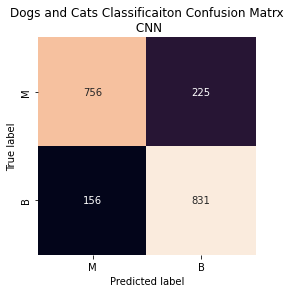

In [ ]:
# Using Seaborn to display Confusion Matrix Beautifully
# Transform to df for easier plotting

cm_df = pd.DataFrame(conf_mat,
                     index = ['M','B'], 
                     columns = ['M','B'])

plt.figure(figsize=(4,4))
sns.heatmap(cm_df, annot=True, square=True, cbar=False, fmt="d")
plt.title('Dogs and Cats Classificaiton Confusion Matrx\n CNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
# plt.figtext(1.30, 0.01, 'Accuracy: {}%\n Sensitivity: {}\n Specificity: {} '.format(round(svc_accuracy, 2),round(sensitivity, 2),round(specificity, 2)), horizontalalignment='right')
plt.show()

### Display Test Results on Individual Images

In [ ]:
# Note: The model has not seen these images before
# Importing modules for loading, transforming and displaying images
from IPython.display import display
from PIL import Image
import os
from keras.preprocessing import image

dog_test_data_dir = f"{test_data_dir}/dogs"
cat_test_data_dir = f"{test_data_dir}/cats"

# read all images in test directory
img_paths = []
for imgs in os.listdir(dog_test_data_dir):
    #print(imgs)
    file = f"{dog_test_data_dir}/{imgs}"
    img_paths.append(file)

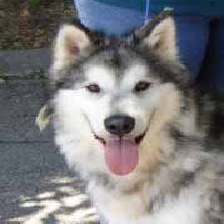

Dog


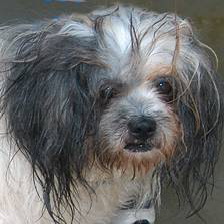

Dog


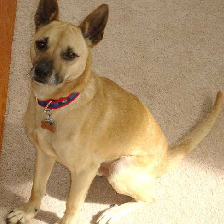

Cat


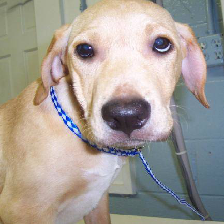

Dog


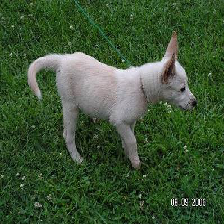

Dog


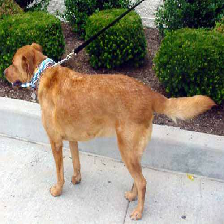

Dog


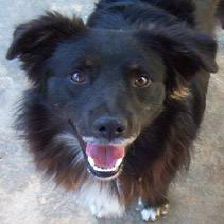

Dog


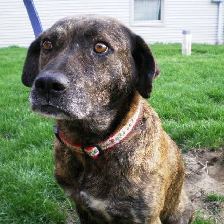

Dog


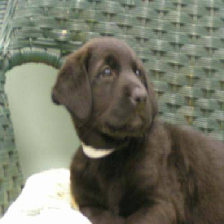

Dog


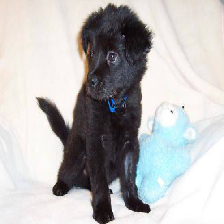

Dog


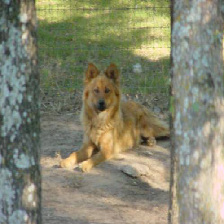

Dog


In [ ]:
# Testing the custom trained ConvNet model 
for i,(img) in enumerate(img_paths):
    img = image.load_img(img, target_size=(img_width, img_height))
    display(img)
    
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    result = full_model.predict(img)
    #result = vgg_binary.predict(img)
    if result[0][0] >= 0.5:
        prediction = 'Dog'
    else:
        prediction = 'Cat'
        
    print(prediction)

    if(i>9):
      break

# Assignment

Build an MLP (fully connected layer) and CNN model to recognize digits using this dataset
https://www.kaggle.com/c/digit-recognizer